In [148]:
import pandas as pd
import numpy as np
import re

# библиотеки для кодирования данных
import category_encoders as ce
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

from sklearn.model_selection import train_test_split # инструмент для разбивки данных
 
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\polub\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 1. Анализ данных

Первоначальная версия датасета содержит 17 полей со следующей информацией:

hotel_address — адрес отеля;

review_date — дата, когда рецензент разместил соответствующий отзыв;

average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

hotel_name — название отеля;

reviewer_nationality — страна рецензента;

negative_review — отрицательный отзыв, который рецензент дал отелю;

review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

positive_review — положительный отзыв, который рецензент дал отелю;

review_total_positive_word_counts — общее количество слов в положительном отзыве.

reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;

total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

total_number_of_reviews — общее количество действительных отзывов об отеле;

tags — теги, которые рецензент дал отелю;

days_since_review — количество дней между датой проверки и датой очистки;

additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число 
указывает, сколько там действительных оценок без проверки.

lat — географическая широта отеля;

lng — географическая долгота отеля.

In [149]:
hotels = pd.read_csv('data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [150]:
# Ответы на задание 2.1-2.4
display(hotels.info())
display('Пропуски значений обнаружены в столбцах "lat" и "lng"')
display(f'Столбцы с числовым форматом: {list(hotels.select_dtypes(include=["int", "float"]).columns)}')
display('Стобцы со строковым форматом: "hotel_address", "hotel_name", "reviewer_nationality", "negative_review", "positive_review", "tags", "day_since_review"')
display('Стобец, содержащий дату: "review_date"')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

'Пропуски значений обнаружены в столбцах "lat" и "lng"'

"Столбцы с числовым форматом: ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat', 'lng']"

'Стобцы со строковым форматом: "hotel_address", "hotel_name", "reviewer_nationality", "negative_review", "positive_review", "tags", "day_since_review"'

'Стобец, содержащий дату: "review_date"'

In [151]:
# Ответ на задание 4.2
display(f"Число отелей в базе данных: {hotels['hotel_name'].nunique()}")

'Число отелей в базе данных: 1492'

In [152]:
# Изменение формата признака с датой отзыва
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%m/%d/%Y')

In [153]:
# Ответ на задание 4.3
display(f"Самая старый отзыв: {hotels['review_date'].min()}")
display(f"Самая свежий отзыв: {hotels['review_date'].max()}")


'Самая старый отзыв: 2015-08-04 00:00:00'

'Самая свежий отзыв: 2017-08-03 00:00:00'

In [154]:
# Ответы на задание 4.4-4.6
# Определим уникальное количество тегов в наборе данных
def re_func(num_tags):
    """Функция, которая принимает теги отелей и возвращает список для каждой записи

    Args:
        num_tags (list): список тегов для отеля

    Returns:
        lits: список тегов для записи
    """
    found = re.findall("'[^\'](.+?)[^\']'", num_tags)
    return found


# Новый признак признак 'tags_n'
hotels['tags_n'] = hotels['tags'].apply(re_func)
df = hotels.explode('tags_n') 

display(f"Число уникальных тегов: {df['tags_n'].nunique()}")
display(df['tags_n'].value_counts(normalize=True).head(10)*100) # 10 наиболее популярных тегов

'Число уникальных тегов: 2368'

Leisure trip                      17.741957
Submitted from a mobile device    13.056584
Couple                            10.704930
Stayed 1 night                     8.224678
Stayed 2 nights                    5.672518
Solo traveler                      4.595982
Stayed 3 nights                    4.073500
Business trip                      3.507113
Group                              2.777221
Family with young children         2.593235
Name: tags_n, dtype: float64

### 2. Обработка пропущенных значений

Как показали результаты анализа данных пропуски значений встречаются в признаках "lat" и "lng". Проведем анализ распределения координат отелей.

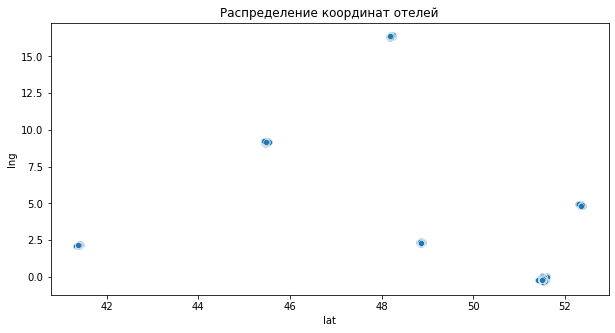

In [155]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=hotels, x='lat', y='lng')
plt.title('Распределение координат отелей');

In [156]:
# Определение записей содержаших пропуски
lat_mask = hotels['lat'].isnull()
lng_mask = hotels['lng'].isnull()

In [157]:
null_addresses = list(set(hotels[lat_mask]['hotel_address']))
null_city = []
for x in null_addresses:
    null_city.append(x.split(' ')[-2])
display(set(null_city))
display(f'Количество уникальных значений городов, для которых обнаружены пропуски: {len(set(null_city))}')

{'Barcelona', 'Paris', 'Vienna'}

'Количество уникальных значений городов, для которых обнаружены пропуски: 3'

По результатам анализа построенного распределения координат отелей, можно сделать вывод, что все отели распределенв между шестью географических единиц. В качестве значения для заполнения пропусков можно использовать координаты начала улицы, на которой расположен отель. Количество уникальных адресов, для которых имеются пропуски, составляет 17 шт.


In [158]:
# Координаты центров городов для заполнения пропусков
center_coordinates = {'Vienna': [48.2167, 16.3733],
             'Barcelona': [41.3888, 2.15899],
             'Paris': [48.5112, 2.2055]}

In [159]:
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-2]+' '+x.split(' ')[-1] if 
                                                        x.split(' ')[-1] == 'Kingdom' else x.split(' ')[-1])

In [160]:
hotels['hotel_country'].value_counts()

United Kingdom    196774
Spain              45132
France             44830
Netherlands        43006
Austria            29178
Italy              27883
Name: hotel_country, dtype: int64

In [161]:
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: 'London' if x.split(' ')[-1] == 'Kingdom' else x.split(' ')[-2])

In [162]:
hotels['hotel_city'].value_counts()

London       196774
Barcelona     45132
Paris         44830
Amsterdam     43006
Vienna        29178
Milan         27883
Name: hotel_city, dtype: int64

In [164]:
hotels.loc[(lat_mask & (hotels['hotel_city'] == 'Vienna')), 'lat'] = center_coordinates['Vienna'][0]
hotels.loc[(lng_mask & (hotels['hotel_city'] == 'Vienna')), 'lng'] = center_coordinates['Vienna'][1]
hotels.loc[(lat_mask & (hotels['hotel_city'] == 'Barcelona')), 'lat'] = center_coordinates['Barcelona'][0]
hotels.loc[(lng_mask & (hotels['hotel_city'] == 'Barcelona')), 'lng'] = center_coordinates['Barcelona'][1]
hotels.loc[(lat_mask & (hotels['hotel_city'] == 'Paris')), 'lat'] = center_coordinates['Paris'][0]
hotels.loc[(lng_mask & (hotels['hotel_city'] == 'Paris')), 'lng'] = center_coordinates['Paris'][1]

### 3. Преобразование и создание новых признаков

#### 3.1 Признак hotel_name

In [116]:
display(f"Количество уникальных наименований отелей: {hotels['hotel_name'].nunique()}")

'Количество уникальных наименований отелей: 1492'

In [117]:
# Произведем кодирование признака с наименованием отелей
le = LabelEncoder()
hotels['hotel_name_code'] = le.fit_transform(hotels['hotel_name'])

#### 3.2 Признак tags

In [118]:
# Создадим признак, описывающий тип поездки
def get_type_trip(tags:list):
    """Функция для определения типа поездки из тега

    Args:
        tags (list): Список тегов

    Returns:
        str: Тип поездки
    """
    for tag in tags:
        if tag == 'Business trip':
            return 'Business trip'
        elif tag == 'Leisure trip':
            return 'Leisure trip'
    return 'Other'


hotels['type_trip'] = hotels['tags_n'].apply(get_type_trip)
 

In [119]:
# Кодировка признака типа поездки
encoder = ce.OneHotEncoder(cols=['type_trip'])
type_bin = encoder.fit_transform(hotels['type_trip'])
hotels = pd.concat([hotels, type_bin], axis=1)

c:\Users\polub\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [120]:
# Создадим признак, описывающий количество ночей, проведенных в отеле
def get_nights(tags:list):
    for tag in tags:
        if tag == 'Stayed 1 night':
            return 'Stayed 1 night'
        elif tag == 'Stayed 2 nights':
            return 'Stayed 2 nights'
    return 'More than 2 nights'


hotels['nights_count'] = hotels['tags_n'].apply(get_nights)

In [121]:
# Кодировка признака количества проведенных ночей в отеле
encoder = ce.OneHotEncoder(cols=['nights_count'])
type_bin = encoder.fit_transform(hotels['nights_count'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [122]:
# Кодировка признаков страны и города отеля
encoder = ce.OneHotEncoder(cols=['hotel_country', 'hotel_city'])
type_bin = encoder.fit_transform(hotels[['hotel_country', 'hotel_city']])
hotels = pd.concat([hotels, type_bin], axis=1)

#### 3.3 Признак reviewer_nationality

In [123]:
display(f"Количество уникальных национальностей: {hotels['reviewer_nationality'].nunique()}")

'Количество уникальных национальностей: 225'

In [124]:
# Кодировка признака национальности автора отзыва
le = LabelEncoder()
hotels['reviewer_nationality'] = le.fit_transform(hotels['reviewer_nationality'])


#### 3.4 Признак review_date

In [125]:
# Создание новых признаков на основе даты отзыва
hotels['review_month'] = hotels['review_date'].dt.month.astype(int)
hotels['review_weekday'] = hotels['review_date'].dt.dayofweek.astype(int)
hotels['days_since_review'] = ((hotels['review_date'].max() - hotels['review_date'])/np.timedelta64(1,'D')).astype(int)

In [126]:
hotels.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,hotel_country_5,hotel_country_6,hotel_city_1,hotel_city_2,hotel_city_3,hotel_city_4,hotel_city_5,hotel_city_6,review_month,review_weekday
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,213,Leaving,3,1994,Staff were amazing,...,0,0,1,0,0,0,0,0,2,4


#### 3.5 Признаки negative_review и positive_review

In [89]:
# Воспользуемся библиотекой обработки текста для определения контекста отзыва
sent_analyzer = SentimentIntensityAnalyzer()

hotels['rev_neg'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
hotels['rev_pos'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

hotels.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(hotels['rev_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
hotels.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(hotels['rev_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

### 4. Отбор признаков

In [141]:
# Удаление обработанных тектовых признаков
object_columns = [col for col in hotels.columns if hotels[col].dtypes == 'object']
date_columns = ['review_date']

hotels.drop(object_columns, axis=1, inplace=True)
hotels.drop(date_columns, axis=1, inplace=True)

In [143]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [118]:
# Формирование списка непрервывных признаков
num_cols = ['additional_number_of_scoring','review_total_negative_word_counts', 'total_number_of_reviews', 
            'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']

# Формированике списка категориальных признаков
cat_cols = ['average_score', 'lat', ]

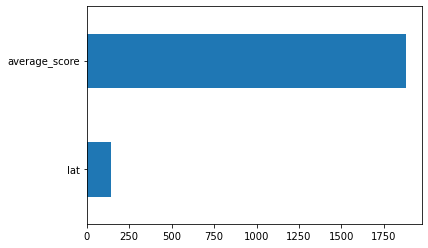

In [119]:
# Оценка значимости категориальных признаков
y = y.astype('int')

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

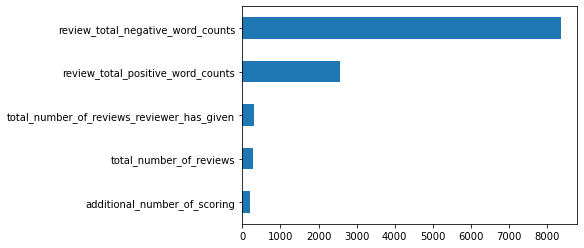

In [120]:
# Оценка значимости непрерывных признаков
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');


### 5. Создание и обучение модели

In [144]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [145]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [146]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13566681025339344
